# Importing the libraries

In [11]:
import numpy as np
import simpy
import time
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Define the Drone and User classes

In [ ]:
class Drone:
    def __init__(self, env, id, position):
        self.env = env
        self.id = id
        self.position = position
        self.best_position = position.copy()
        self.best_coverage = 0

class User:
    def __init__(self, env, id, position):
        self.env = env
        self.id = id
        self.position = position

# Function to calculate coverage

In [ ]:
def calculate_coverage(drones, users, coverage_radius=20):
    coverage = 0
    for user in users:
        if any(np.linalg.norm(drone.position - user.position) <= coverage_radius for drone in drones):
            coverage += 1
    return coverage

# Function to evaluate KPIs
def evaluate_kpis(drones, users, coverage_radius=20, exec_time=0):
    coverage = calculate_coverage(drones, users, coverage_radius)
    total_signal_strength = 0
    total_energy_consumption = 0
    
    for drone in drones:
        signal_strength = -20 * np.log10(np.linalg.norm(drone.position))  # Placeholder
        total_signal_strength += signal_strength
        energy_consumption = 100  # Placeholder
        total_energy_consumption += energy_consumption
    
    average_signal_strength = total_signal_strength / len(drones)
    average_energy_consumption = total_energy_consumption / len(drones)
    
    kpis = {
        'Coverage': coverage,
        'Average Signal Strength': average_signal_strength,
        'Average Energy Consumption': average_energy_consumption,
        'Execution Time (s)': exec_time  # Adding execution time to KPIs
    }
    return kpis

# Random Placement Method

In [ ]:
def random_placement(env, num_drones, area_size):
    drones = [Drone(env, i, np.random.random(2) * area_size) for i in range(num_drones)]
    return drones

# Grid-Based Placement Method

In [ ]:
def grid_based_placement(env, num_drones, area_size):
    grid_size = int(np.sqrt(num_drones))
    positions = [(i * area_size / grid_size, j * area_size / grid_size) for i in range(grid_size) for j in range(grid_size)]

    # If there are more drones than grid positions, repeat positions
    while len(positions) < num_drones:
        positions.extend(positions[:num_drones - len(positions)])

    drones = [Drone(env, i, np.array(positions[i])) for i in range(num_drones)]
    return drones

# Greedy Algorithm Method

In [ ]:
def greedy_placement(env, num_drones, users, area_size, coverage_radius=20):
    drones = []
    uncovered_users = users.copy()
    
    for i in range(num_drones):
        best_position = None
        max_covered = 0
        
        for x in np.linspace(0, area_size, 10):
            for y in np.linspace(0, area_size, 10):
                position = np.array([x, y])
                coverage = sum(np.linalg.norm(position - user.position) <= coverage_radius for user in uncovered_users)
                
                if coverage > max_covered:
                    max_covered = coverage
                    best_position = position
        
        if best_position is not None:
            drones.append(Drone(env, i, best_position))
            uncovered_users = [user for user in uncovered_users if np.linalg.norm(best_position - user.position) > coverage_radius]
    return drones

# Particle Swarm Optimization Method

In [ ]:
def pso_placement(env, num_drones, users, area_size, coverage_radius=20, iterations=100):
    drones = [Drone(env, i, np.random.random(2) * area_size) for i in range(num_drones)]
    velocities = [np.random.random(2) for _ in range(num_drones)]
    global_best_position = np.random.random(2) * area_size
    global_best_coverage = 0
    
    for _ in tqdm(range(iterations), desc="PSO Iterations", leave=False):
        for drone, velocity in zip(drones, velocities):
            inertia = 0.7 * velocity
            cognitive = 1.5 * np.random.random() * (drone.best_position - drone.position)
            social = 1.5 * np.random.random() * (global_best_position - drone.position)
            velocity = inertia + cognitive + social
            
            drone.position += velocity
            drone.position = np.clip(drone.position, 0, area_size)
            
            current_coverage = calculate_coverage([drone], users, coverage_radius)
            if current_coverage > drone.best_coverage:
                drone.best_coverage = current_coverage
                drone.best_position = drone.position.copy()
            
            if current_coverage > global_best_coverage:
                global_best_coverage = current_coverage
                global_best_position = drone.position.copy()
    return drones

# Modified Dispersive flies optimisation(DFO) Algorithm Method

In [ ]:
# Function to calculate repulsion force
def calculate_repulsion(drones, repulsion_distance=10, repulsion_factor=1.5):
    forces = [np.zeros(2) for _ in range(len(drones))]
    for i in range(len(drones)):
        for j in range(i + 1, len(drones)):
            distance = np.linalg.norm(drones[i].position - drones[j].position)
            if distance < repulsion_distance and distance > 0:
                force_direction = (drones[i].position - drones[j].position) / distance
                force_magnitude = repulsion_factor * (repulsion_distance - distance)
                forces[i] += force_direction * force_magnitude
                forces[j] -= force_direction * force_magnitude
    return forces

# Dispersive flies optimisation (DFO) Algorithm Method
def advanced_dfo_algorithm(drones, users, num_iterations=100, coverage_radius=20, alpha=2.0, beta=0.5, gamma=1.0, delta=0.01):
    def update_positions(drones, global_best_position, inertia_weight):
        repulsion_distance = 10
        repulsion_forces = calculate_repulsion(drones, repulsion_distance)
        
        for drone, repulsion_force in zip(drones, repulsion_forces):
            inertia = inertia_weight * (drone.best_position - drone.position)
            drone.position += gamma * inertia
            random_step = alpha * (np.random.random(2) - 0.5)
            drone.position += random_step
            global_attraction = beta * (global_best_position - drone.position)
            drone.position += global_attraction
            drone.position += repulsion_force
            drone.position = np.clip(drone.position, 0, 100)
    
    global_best_position = max(drones, key=lambda drone: drone.best_coverage).best_position
    global_best_coverage = max(drones, key=lambda drone: drone.best_coverage).best_coverage
    
    inertia_weight = 0.9
    inertia_decay = 0.99
    
    for _ in tqdm(range(num_iterations), desc="DFO Iterations", leave=False):
        for drone in drones:
            current_coverage = calculate_coverage(drones, users, coverage_radius)
            if current_coverage > drone.best_coverage:
                drone.best_coverage = current_coverage
                drone.best_position = drone.position.copy()
        
        current_global_best_drone = max(drones, key=lambda drone: drone.best_coverage)
        if current_global_best_drone.best_coverage > global_best_coverage:
            global_best_position = current_global_best_drone.best_position
            global_best_coverage = current_global_best_drone.best_coverage
        
        update_positions(drones, global_best_position, inertia_weight)
        
        alpha *= (1 - delta)
        beta *= (1 - delta)
        gamma *= (1 - delta)
        inertia_weight *= inertia_decay
        
        if np.linalg.norm(global_best_position - np.mean([drone.position for drone in drones], axis=0)) < 1e-3:
            break
    return drones, global_best_position


# Simulation Setup

In [9]:

def run_simulation_and_evaluate_kpis():
    env = simpy.Environment()
    
    # Define parameter combinations
    area_sizes = [20,30,50, 100]
    num_drones_list = [10, 20, 30,40,50,60]
    num_users_list = [50, 100, 150]

    # Initialize an empty list to hold all the results
    all_results = []

    total_combinations = len(area_sizes) * len(num_drones_list) * len(num_users_list)
    with tqdm(total=total_combinations, desc="Total Simulations") as pbar:
        for area_size in area_sizes:
            for num_drones in num_drones_list:
                for num_users in num_users_list:
                    print(f"Running simulation with area_size={area_size}, num_drones={num_drones}, num_users={num_users}")
                    users = [User(env, i, np.random.random(2) * area_size) for i in range(num_users)]
                    # Run each method with timing
                    start_time = time.time()
                    random_drones = random_placement(env, num_drones, area_size)
                    random_time = time.time() - start_time

                    start_time = time.time()
                    grid_drones = grid_based_placement(env, num_drones, area_size)
                    grid_time = time.time() - start_time

                    start_time = time.time()
                    greedy_drones = greedy_placement(env, num_drones, users, area_size)
                    greedy_time = time.time() - start_time

                    start_time = time.time()
                    pso_drones = pso_placement(env, num_drones, users, area_size)
                    pso_time = time.time() - start_time

                    start_time = time.time()
                    dfo_drones, _ = advanced_dfo_algorithm(random_drones, users, num_iterations=100, coverage_radius=20)
                    dfo_time = time.time() - start_time

                    # Evaluate KPIs for each method with execution time
                    random_kpis = evaluate_kpis(random_drones, users, exec_time=random_time)
                    grid_kpis = evaluate_kpis(grid_drones, users, exec_time=grid_time)
                    greedy_kpis = evaluate_kpis(greedy_drones, users, exec_time=greedy_time)
                    pso_kpis = evaluate_kpis(pso_drones, users, exec_time=pso_time)
                    dfo_kpis = evaluate_kpis(dfo_drones, users, exec_time=dfo_time)

                    # Append the results to the list
                    all_results.append({
                        'Method': 'Random',
                        'Area Size': area_size,
                        'Number of Drones': num_drones,
                        'Number of Users': num_users,
                        **random_kpis
                    })
                    all_results.append({
                        'Method': 'Grid',
                        'Area Size': area_size,
                        'Number of Drones': num_drones,
                        'Number of Users': num_users,
                        **grid_kpis
                    })
                    all_results.append({
                        'Method': 'Greedy',
                        'Area Size': area_size,
                        'Number of Drones': num_drones,
                        'Number of Users': num_users,
                        **greedy_kpis
                    })
                    all_results.append({
                        'Method': 'PSO',
                        'Area Size': area_size,
                        'Number of Drones': num_drones,
                        'Number of Users': num_users,
                        **pso_kpis
                    })
                    all_results.append({
                        'Method': 'DFO',
                        'Area Size': area_size,
                        'Number of Drones': num_drones,
                        'Number of Users': num_users,
                        **dfo_kpis
                    })

                    pbar.update(1)  # Update progress bar after each simulation

    # Convert the results into a DataFrame
    df = pd.DataFrame(all_results)

    # Save the DataFrame to a CSV file
    df.to_csv('simulation_kpi_results.csv', index=False)
    print("Simulation complete. Results saved to simulation_kpi_results.csv.")

# Run the simulation and save KPIs for multiple combinations
run_simulation_and_evaluate_kpis()


Total Simulations:   0%|                                                                        | 0/72 [00:00<?, ?it/s]

Running simulation with area_size=20, num_drones=10, num_users=50



PSO Iterations:  80%|███████████████████████████████████████████████████▏            | 80/100 [00:00<00:00, 797.35it/s]
                                                                                                                       
Total Simulations:   1%|▉                                                               | 1/72 [00:00<00:25,  2.78it/s]

Running simulation with area_size=20, num_drones=10, num_users=100



PSO Iterations:  76%|████████████████████████████████████████████████▋               | 76/100 [00:00<00:00, 378.16it/s]
                                                                                                                       
Total Simulations:   3%|█▊                                                              | 2/72 [00:01<00:38,  1.83it/s]

Running simulation with area_size=20, num_drones=10, num_users=150



PSO Iterations:  82%|████████████████████████████████████████████████████▍           | 82/100 [00:00<00:00, 236.13it/s]
                                                                                                                       
Total Simulations:   4%|██▋                                                             | 3/72 [00:02<00:50,  1.35it/s]

Running simulation with area_size=20, num_drones=20, num_users=50



PSO Iterations:  82%|████████████████████████████████████████████████████▍           | 82/100 [00:00<00:00, 385.03it/s]
                                                                                                                       
Total Simulations:   6%|███▌                                                            | 4/72 [00:02<00:49,  1.38it/s]

Running simulation with area_size=20, num_drones=20, num_users=100



PSO Iterations:  99%|███████████████████████████████████████████████████████████████▎| 99/100 [00:00<00:00, 188.90it/s]
                                                                                                                       
Total Simulations:   7%|████▍                                                           | 5/72 [00:04<01:06,  1.01it/s]

Running simulation with area_size=20, num_drones=20, num_users=150



PSO Iterations:  99%|███████████████████████████████████████████████████████████████▎| 99/100 [00:01<00:00, 104.34it/s]
                                                                                                                       
Total Simulations:   8%|█████▎                                                          | 6/72 [00:06<01:35,  1.45s/it]

Running simulation with area_size=20, num_drones=30, num_users=50



PSO Iterations:  95%|████████████████████████████████████████████████████████████▊   | 95/100 [00:00<00:00, 180.38it/s]
                                                                                                                       
Total Simulations:  10%|██████▏                                                         | 7/72 [00:08<01:35,  1.47s/it]

Running simulation with area_size=20, num_drones=30, num_users=100



PSO Iterations:  99%|████████████████████████████████████████████████████████████████▎| 99/100 [00:01<00:00, 83.80it/s]
                                                                                                                       
Total Simulations:  11%|███████                                                         | 8/72 [00:11<02:06,  1.98s/it]

Running simulation with area_size=20, num_drones=30, num_users=150



PSO Iterations:  99%|████████████████████████████████████████████████████████████████▎| 99/100 [00:01<00:00, 73.89it/s]
                                                                                                                       
Total Simulations:  12%|████████                                                        | 9/72 [00:14<02:41,  2.57s/it]

Running simulation with area_size=20, num_drones=40, num_users=50



PSO Iterations:  89%|████████████████████████████████████████████████████████▉       | 89/100 [00:00<00:00, 133.50it/s]
                                                                                                                       
Total Simulations:  14%|████████▊                                                      | 10/72 [00:17<02:30,  2.42s/it]

Running simulation with area_size=20, num_drones=40, num_users=100



PSO Iterations:  99%|████████████████████████████████████████████████████████████████▎| 99/100 [00:01<00:00, 72.54it/s]
                                                                                                                       
Total Simulations:  15%|█████████▋                                                     | 11/72 [00:20<02:51,  2.82s/it]

Running simulation with area_size=20, num_drones=40, num_users=150



PSO Iterations:  98%|███████████████████████████████████████████████████████████████▋ | 98/100 [00:02<00:00, 43.80it/s]
                                                                                                                       
Total Simulations:  17%|██████████▌                                                    | 12/72 [00:26<03:47,  3.79s/it]

Running simulation with area_size=20, num_drones=50, num_users=50



PSO Iterations:  93%|███████████████████████████████████████████████████████████▌    | 93/100 [00:00<00:00, 124.93it/s]
                                                                                                                       
Total Simulations:  18%|███████████▍                                                   | 13/72 [00:29<03:22,  3.43s/it]

Running simulation with area_size=20, num_drones=50, num_users=100



PSO Iterations:  98%|███████████████████████████████████████████████████████████████▋ | 98/100 [00:01<00:00, 64.09it/s]
                                                                                                                       
Total Simulations:  19%|████████████▎                                                  | 14/72 [00:34<03:57,  4.09s/it]

Running simulation with area_size=20, num_drones=50, num_users=150



PSO Iterations:  98%|███████████████████████████████████████████████████████████████▋ | 98/100 [00:03<00:00, 27.27it/s]
                                                                                                                       
Total Simulations:  21%|█████████████▏                                                 | 15/72 [00:43<05:15,  5.53s/it]

Running simulation with area_size=20, num_drones=60, num_users=50



PSO Iterations:  89%|█████████████████████████████████████████████████████████▊       | 89/100 [00:00<00:00, 89.00it/s]
                                                                                                                       
Total Simulations:  22%|██████████████                                                 | 16/72 [00:47<04:40,  5.01s/it]

Running simulation with area_size=20, num_drones=60, num_users=100



PSO Iterations:  98%|███████████████████████████████████████████████████████████████▋ | 98/100 [00:01<00:00, 47.05it/s]
                                                                                                                       
Total Simulations:  24%|██████████████▉                                                | 17/72 [00:53<04:47,  5.23s/it]

Running simulation with area_size=20, num_drones=60, num_users=150



PSO Iterations:  97%|███████████████████████████████████████████████████████████████  | 97/100 [00:02<00:00, 34.60it/s]
                                                                                                                       
Total Simulations:  25%|███████████████▊                                               | 18/72 [01:02<05:37,  6.25s/it]

Running simulation with area_size=30, num_drones=10, num_users=50



PSO Iterations:  57%|████████████████████████████████████▍                           | 57/100 [00:00<00:00, 566.26it/s]
                                                                                                                       
Total Simulations:  26%|████████████████▋                                              | 19/72 [01:02<03:59,  4.52s/it]

Running simulation with area_size=30, num_drones=10, num_users=100



PSO Iterations:  81%|███████████████████████████████████████████████████▊            | 81/100 [00:00<00:00, 206.67it/s]
                                                                                                                       
Total Simulations:  28%|█████████████████▌                                             | 20/72 [01:03<03:01,  3.48s/it]

Running simulation with area_size=30, num_drones=10, num_users=150



PSO Iterations:  97%|██████████████████████████████████████████████████████████████  | 97/100 [00:00<00:00, 149.63it/s]
                                                                                                                       
Total Simulations:  29%|██████████████████▍                                            | 21/72 [01:05<02:28,  2.92s/it]

Running simulation with area_size=30, num_drones=20, num_users=50



PSO Iterations:  98%|██████████████████████████████████████████████████████████████▋ | 98/100 [00:00<00:00, 311.08it/s]
                                                                                                                       
Total Simulations:  31%|███████████████████▎                                           | 22/72 [01:06<01:58,  2.38s/it]

Running simulation with area_size=30, num_drones=20, num_users=100



PSO Iterations:  90%|█████████████████████████████████████████████████████████▌      | 90/100 [00:00<00:00, 136.00it/s]
                                                                                                                       
Total Simulations:  32%|████████████████████▏                                          | 23/72 [01:08<01:52,  2.30s/it]

Running simulation with area_size=30, num_drones=20, num_users=150



PSO Iterations:  93%|████████████████████████████████████████████████████████████▍    | 93/100 [00:00<00:00, 90.76it/s]
                                                                                                                       
Total Simulations:  33%|█████████████████████                                          | 24/72 [01:11<01:55,  2.40s/it]

Running simulation with area_size=30, num_drones=30, num_users=50



PSO Iterations:  94%|████████████████████████████████████████████████████████████▏   | 94/100 [00:00<00:00, 169.07it/s]
                                                                                                                       
Total Simulations:  35%|█████████████████████▉                                         | 25/72 [01:12<01:46,  2.27s/it]

Running simulation with area_size=30, num_drones=30, num_users=100



PSO Iterations:  94%|████████████████████████████████████████████████████████████▏   | 94/100 [00:00<00:00, 100.47it/s]
                                                                                                                       
Total Simulations:  36%|██████████████████████▊                                        | 26/72 [01:15<01:52,  2.45s/it]

Running simulation with area_size=30, num_drones=30, num_users=150



PSO Iterations: 100%|████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 62.85it/s]
                                                                                                                       
Total Simulations:  38%|███████████████████████▋                                       | 27/72 [01:22<02:42,  3.62s/it]

Running simulation with area_size=30, num_drones=40, num_users=50



PSO Iterations:  99%|███████████████████████████████████████████████████████████████▎| 99/100 [00:00<00:00, 127.94it/s]
                                                                                                                       
Total Simulations:  39%|████████████████████████▌                                      | 28/72 [01:24<02:21,  3.21s/it]

Running simulation with area_size=30, num_drones=40, num_users=100



PSO Iterations:  97%|███████████████████████████████████████████████████████████████  | 97/100 [00:01<00:00, 67.95it/s]
                                                                                                                       
Total Simulations:  40%|█████████████████████████▍                                     | 29/72 [01:28<02:32,  3.54s/it]

Running simulation with area_size=30, num_drones=40, num_users=150



PSO Iterations:  96%|██████████████████████████████████████████████████████████████▍  | 96/100 [00:02<00:00, 50.44it/s]
                                                                                                                       
Total Simulations:  42%|██████████████████████████▎                                    | 30/72 [01:34<03:02,  4.34s/it]

Running simulation with area_size=30, num_drones=50, num_users=50



PSO Iterations:  91%|███████████████████████████████████████████████████████████▏     | 91/100 [00:00<00:00, 97.79it/s]
                                                                                                                       
Total Simulations:  43%|███████████████████████████▏                                   | 31/72 [01:38<02:46,  4.07s/it]

Running simulation with area_size=30, num_drones=50, num_users=100



PSO Iterations:  99%|████████████████████████████████████████████████████████████████▎| 99/100 [00:02<00:00, 53.52it/s]
                                                                                                                       
Total Simulations:  44%|████████████████████████████                                   | 32/72 [01:44<03:02,  4.57s/it]

Running simulation with area_size=30, num_drones=50, num_users=150



PSO Iterations: 100%|████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.16it/s]
                                                                                                                       
Total Simulations:  46%|████████████████████████████▉                                  | 33/72 [01:52<03:41,  5.67s/it]

Running simulation with area_size=30, num_drones=60, num_users=50



PSO Iterations:  90%|██████████████████████████████████████████████████████████▌      | 90/100 [00:01<00:00, 77.06it/s]
                                                                                                                       
Total Simulations:  47%|█████████████████████████████▊                                 | 34/72 [01:56<03:17,  5.21s/it]

Running simulation with area_size=30, num_drones=60, num_users=100



PSO Iterations:  97%|███████████████████████████████████████████████████████████████  | 97/100 [00:01<00:00, 55.82it/s]
                                                                                                                       
Total Simulations:  49%|██████████████████████████████▋                                | 35/72 [02:02<03:23,  5.51s/it]

Running simulation with area_size=30, num_drones=60, num_users=150



PSO Iterations:  96%|██████████████████████████████████████████████████████████████▍  | 96/100 [00:02<00:00, 36.27it/s]
                                                                                                                       
Total Simulations:  50%|███████████████████████████████▌                               | 36/72 [02:12<04:08,  6.89s/it]

Running simulation with area_size=50, num_drones=10, num_users=50



PSO Iterations:  43%|███████████████████████████▌                                    | 43/100 [00:00<00:00, 416.68it/s]
                                                                                                                       
Total Simulations:  51%|████████████████████████████████▍                              | 37/72 [02:13<02:57,  5.08s/it]

Running simulation with area_size=50, num_drones=10, num_users=100



PSO Iterations:  67%|██████████████████████████████████████████▉                     | 67/100 [00:00<00:00, 342.94it/s]
                                                                                                                       
Total Simulations:  53%|█████████████████████████████████▎                             | 38/72 [02:15<02:19,  4.11s/it]

Running simulation with area_size=50, num_drones=10, num_users=150



PSO Iterations:  92%|██████████████████████████████████████████████████████████▉     | 92/100 [00:00<00:00, 178.90it/s]
                                                                                                                       
Total Simulations:  54%|██████████████████████████████████▏                            | 39/72 [02:17<01:58,  3.60s/it]

Running simulation with area_size=50, num_drones=20, num_users=50



PSO Iterations:  77%|█████████████████████████████████████████████████▎              | 77/100 [00:00<00:00, 339.65it/s]
                                                                                                                       
Total Simulations:  56%|███████████████████████████████████                            | 40/72 [02:20<01:45,  3.31s/it]

Running simulation with area_size=50, num_drones=20, num_users=100



PSO Iterations:  94%|████████████████████████████████████████████████████████████▏   | 94/100 [00:00<00:00, 127.86it/s]
                                                                                                                       
Total Simulations:  57%|███████████████████████████████████▉                           | 41/72 [02:25<01:54,  3.68s/it]

Running simulation with area_size=50, num_drones=20, num_users=150



PSO Iterations:  92%|██████████████████████████████████████████████████████████▉     | 92/100 [00:00<00:00, 112.83it/s]
                                                                                                                       
Total Simulations:  58%|████████████████████████████████████▊                          | 42/72 [02:32<02:19,  4.67s/it]

Running simulation with area_size=50, num_drones=30, num_users=50



PSO Iterations: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 114.91it/s]
                                                                                                                       
Total Simulations:  60%|█████████████████████████████████████▋                         | 43/72 [02:37<02:17,  4.75s/it]

Running simulation with area_size=50, num_drones=30, num_users=100



PSO Iterations:  95%|████████████████████████████████████████████████████████████▊   | 95/100 [00:00<00:00, 100.36it/s]
                                                                                                                       
Total Simulations:  61%|██████████████████████████████████████▌                        | 44/72 [02:41<02:11,  4.70s/it]

Running simulation with area_size=50, num_drones=30, num_users=150



PSO Iterations:  94%|█████████████████████████████████████████████████████████████    | 94/100 [00:02<00:00, 45.22it/s]
                                                                                                                       
Total Simulations:  62%|███████████████████████████████████████▍                       | 45/72 [02:48<02:24,  5.34s/it]

Running simulation with area_size=50, num_drones=40, num_users=50



PSO Iterations:  96%|█████████████████████████████████████████████████████████████▍  | 96/100 [00:00<00:00, 149.59it/s]
                                                                                                                       
Total Simulations:  64%|████████████████████████████████████████▎                      | 46/72 [02:51<02:01,  4.67s/it]

Running simulation with area_size=50, num_drones=40, num_users=100



PSO Iterations:  99%|████████████████████████████████████████████████████████████████▎| 99/100 [00:01<00:00, 65.35it/s]
                                                                                                                       
Total Simulations:  65%|█████████████████████████████████████████▏                     | 47/72 [02:58<02:11,  5.25s/it]

Running simulation with area_size=50, num_drones=40, num_users=150



PSO Iterations:  99%|████████████████████████████████████████████████████████████████▎| 99/100 [00:01<00:00, 58.46it/s]
                                                                                                                       
Total Simulations:  67%|██████████████████████████████████████████                     | 48/72 [03:06<02:27,  6.16s/it]

Running simulation with area_size=50, num_drones=50, num_users=50



PSO Iterations:  96%|█████████████████████████████████████████████████████████████▍  | 96/100 [00:00<00:00, 133.96it/s]
                                                                                                                       
Total Simulations:  68%|██████████████████████████████████████████▉                    | 49/72 [03:11<02:13,  5.82s/it]

Running simulation with area_size=50, num_drones=50, num_users=100



PSO Iterations:  96%|██████████████████████████████████████████████████████████████▍  | 96/100 [00:01<00:00, 61.24it/s]
                                                                                                                       
Total Simulations:  69%|███████████████████████████████████████████▊                   | 50/72 [03:22<02:45,  7.51s/it]

Running simulation with area_size=50, num_drones=50, num_users=150



PSO Iterations:  96%|██████████████████████████████████████████████████████████████▍  | 96/100 [00:02<00:00, 49.48it/s]
                                                                                                                       
Total Simulations:  71%|████████████████████████████████████████████▋                  | 51/72 [03:40<03:38, 10.39s/it]

Running simulation with area_size=50, num_drones=60, num_users=50



PSO Iterations:  93%|████████████████████████████████████████████████████████████▍    | 93/100 [00:01<00:00, 74.38it/s]
                                                                                                                       
Total Simulations:  72%|█████████████████████████████████████████████▌                 | 52/72 [03:47<03:09,  9.49s/it]

Running simulation with area_size=50, num_drones=60, num_users=100



PSO Iterations: 100%|████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 25.98it/s]
                                                                                                                       
Total Simulations:  74%|██████████████████████████████████████████████▍                | 53/72 [04:01<03:26, 10.87s/it]

Running simulation with area_size=50, num_drones=60, num_users=150



PSO Iterations:  99%|████████████████████████████████████████████████████████████████▎| 99/100 [00:02<00:00, 33.87it/s]
                                                                                                                       
Total Simulations:  75%|███████████████████████████████████████████████▎               | 54/72 [04:22<04:11, 13.95s/it]

Running simulation with area_size=100, num_drones=10, num_users=50



PSO Iterations:  71%|█████████████████████████████████████████████▍                  | 71/100 [00:00<00:00, 704.91it/s]
                                                                                                                       
Total Simulations:  76%|████████████████████████████████████████████████▏              | 55/72 [04:24<02:53, 10.21s/it]

Running simulation with area_size=100, num_drones=10, num_users=100



PSO Iterations:  75%|████████████████████████████████████████████████                | 75/100 [00:00<00:00, 375.28it/s]
                                                                                                                       
Total Simulations:  78%|█████████████████████████████████████████████████              | 56/72 [04:26<02:04,  7.80s/it]

Running simulation with area_size=100, num_drones=10, num_users=150



PSO Iterations:  83%|█████████████████████████████████████████████████████           | 83/100 [00:00<00:00, 255.11it/s]
                                                                                                                       
Total Simulations:  79%|█████████████████████████████████████████████████▉             | 57/72 [04:29<01:37,  6.52s/it]

Running simulation with area_size=100, num_drones=20, num_users=50



PSO Iterations:  84%|█████████████████████████████████████████████████████▊          | 84/100 [00:00<00:00, 238.60it/s]
                                                                                                                       
Total Simulations:  81%|██████████████████████████████████████████████████▊            | 58/72 [04:34<01:22,  5.88s/it]

Running simulation with area_size=100, num_drones=20, num_users=100



PSO Iterations:  85%|███████████████████████████████████████████████████████▎         | 85/100 [00:00<00:00, 94.49it/s]
                                                                                                                       
Total Simulations:  82%|███████████████████████████████████████████████████▋           | 59/72 [04:43<01:27,  6.76s/it]

Running simulation with area_size=100, num_drones=20, num_users=150



PSO Iterations:  96%|█████████████████████████████████████████████████████████████▍  | 96/100 [00:01<00:00, 100.96it/s]
                                                                                                                       
Total Simulations:  83%|████████████████████████████████████████████████████▌          | 60/72 [04:54<01:37,  8.14s/it]

Running simulation with area_size=100, num_drones=30, num_users=50



PSO Iterations:  91%|██████████████████████████████████████████████████████████▏     | 91/100 [00:00<00:00, 204.06it/s]
                                                                                                                       
Total Simulations:  85%|█████████████████████████████████████████████████████▍         | 61/72 [05:01<01:25,  7.75s/it]

Running simulation with area_size=100, num_drones=30, num_users=100



PSO Iterations:  87%|███████████████████████████████████████████████████████▋        | 87/100 [00:00<00:00, 136.75it/s]
                                                                                                                       
Total Simulations:  86%|██████████████████████████████████████████████████████▎        | 62/72 [05:16<01:38,  9.88s/it]

Running simulation with area_size=100, num_drones=30, num_users=150



PSO Iterations:  96%|██████████████████████████████████████████████████████████████▍  | 96/100 [00:01<00:00, 81.40it/s]
                                                                                                                       
Total Simulations:  88%|███████████████████████████████████████████████████████▏       | 63/72 [05:34<01:52, 12.48s/it]

Running simulation with area_size=100, num_drones=40, num_users=50



PSO Iterations:  93%|███████████████████████████████████████████████████████████▌    | 93/100 [00:00<00:00, 163.09it/s]
                                                                                                                       
Total Simulations:  89%|████████████████████████████████████████████████████████       | 64/72 [05:43<01:32, 11.52s/it]

Running simulation with area_size=100, num_drones=40, num_users=100



PSO Iterations:  97%|███████████████████████████████████████████████████████████████  | 97/100 [00:01<00:00, 65.82it/s]
                                                                                                                       
Total Simulations:  90%|████████████████████████████████████████████████████████▉      | 65/72 [06:05<01:42, 14.64s/it]

Running simulation with area_size=100, num_drones=40, num_users=150



PSO Iterations:  95%|█████████████████████████████████████████████████████████████▊   | 95/100 [00:01<00:00, 51.27it/s]
                                                                                                                       
Total Simulations:  92%|█████████████████████████████████████████████████████████▊     | 66/72 [06:39<02:02, 20.44s/it]

Running simulation with area_size=100, num_drones=50, num_users=50



PSO Iterations:  93%|███████████████████████████████████████████████████████████▌    | 93/100 [00:00<00:00, 112.23it/s]
                                                                                                                       
Total Simulations:  93%|██████████████████████████████████████████████████████████▋    | 67/72 [06:57<01:37, 19.53s/it]

Running simulation with area_size=100, num_drones=50, num_users=100



PSO Iterations:  99%|████████████████████████████████████████████████████████████████▎| 99/100 [00:02<00:00, 43.61it/s]
                                                                                                                       
Total Simulations:  94%|███████████████████████████████████████████████████████████▌   | 68/72 [07:30<01:34, 23.63s/it]

Running simulation with area_size=100, num_drones=50, num_users=150



PSO Iterations:  99%|████████████████████████████████████████████████████████████████▎| 99/100 [00:02<00:00, 24.83it/s]
                                                                                                                       
Total Simulations:  96%|████████████████████████████████████████████████████████████▍  | 69/72 [08:24<01:38, 32.83s/it]

Running simulation with area_size=100, num_drones=60, num_users=50



PSO Iterations:  94%|████████████████████████████████████████████████████████████▏   | 94/100 [00:01<00:00, 114.59it/s]
                                                                                                                       
Total Simulations:  97%|█████████████████████████████████████████████████████████████▎ | 70/72 [08:46<00:59, 29.58s/it]

Running simulation with area_size=100, num_drones=60, num_users=100



PSO Iterations:  99%|████████████████████████████████████████████████████████████████▎| 99/100 [00:01<00:00, 51.62it/s]
                                                                                                                       
Total Simulations:  99%|██████████████████████████████████████████████████████████████▏| 71/72 [09:26<00:32, 32.55s/it]

Running simulation with area_size=100, num_drones=60, num_users=150



PSO Iterations:  96%|██████████████████████████████████████████████████████████████▍  | 96/100 [00:02<00:00, 36.46it/s]
                                                                                                                       
Total Simulations: 100%|███████████████████████████████████████████████████████████████| 72/72 [10:10<00:00,  8.48s/it]

Simulation complete. Results saved to simulation_kpi_results.csv.


# Evaluation

In [8]:
# Load the data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('simulation_kpi_results.csv')

In [9]:
df

,Method,Area Size,Number of Drones,Number of Users,Coverage,Average Signal Strength,Average Energy Consumption,Execution Time (s)
0,Random,20,10,50,50,-25.694103,100.0,0.000000
1,Grid,20,10,50,50,inf,100.0,0.000000
2,Greedy,20,10,50,50,-19.240239,100.0,0.014232
3,PSO,20,10,50,50,-24.222348,100.0,0.135219
4,DFO,20,10,50,50,-25.694103,100.0,0.207590
...,...,...,...,...,...,...,...,...
355,Random,100,60,150,128,-38.061156,100.0,0.000000
356,Grid,100,60,150,150,inf,100.0,0.000000
357,Greedy,100,60,150,150,inf,100.0,0.150310
358,PSO,100,60,150,59,-37.339012,100.0,2.785677


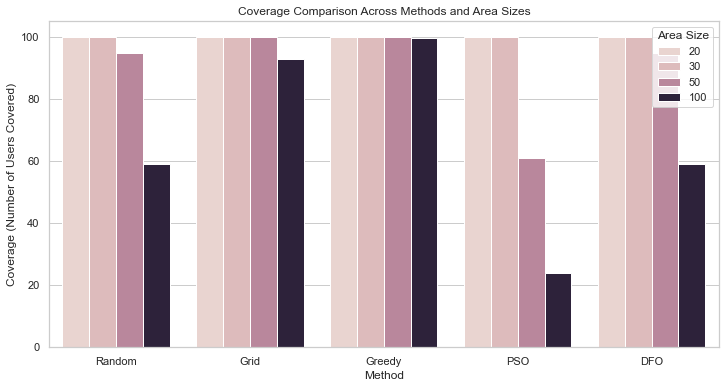

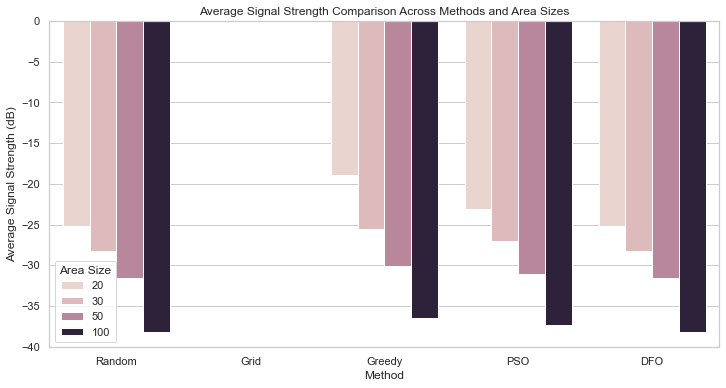

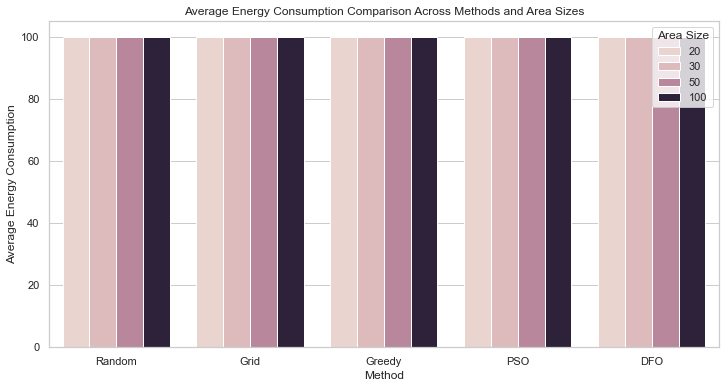

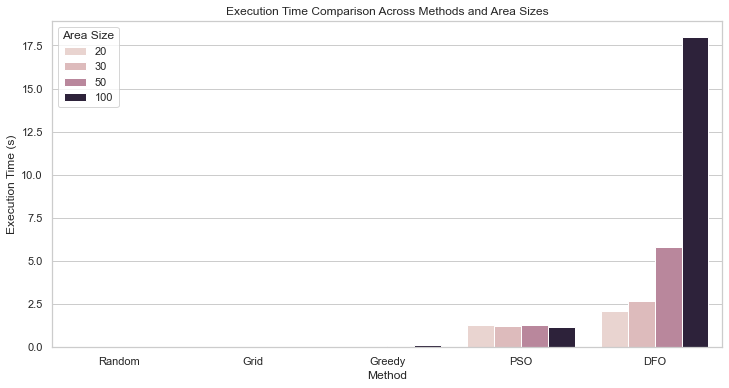

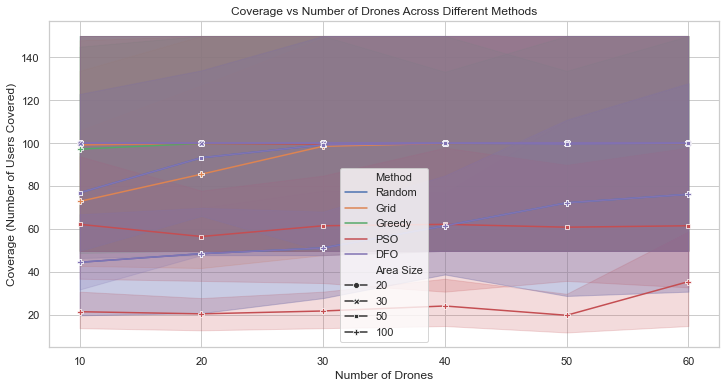

In [12]:
# Display the first few rows to understand the structure
df.head()
# Set up the seaborn style
sns.set(style="whitegrid")

# Plot 1: Coverage comparison across methods
plt.figure(figsize=(12, 6))
sns.barplot(x="Method", y="Coverage", hue="Area Size", data=df, ci=None)
plt.title("Coverage Comparison Across Methods and Area Sizes")
plt.ylabel("Coverage (Number of Users Covered)")
plt.show()

# Plot 2: Average Signal Strength comparison across methods
plt.figure(figsize=(12, 6))
sns.barplot(x="Method", y="Average Signal Strength", hue="Area Size", data=df, ci=None)
plt.title("Average Signal Strength Comparison Across Methods and Area Sizes")
plt.ylabel("Average Signal Strength (dB)")
plt.show()

# Plot 3: Average Energy Consumption comparison across methods
plt.figure(figsize=(12, 6))
sns.barplot(x="Method", y="Average Energy Consumption", hue="Area Size", data=df, ci=None)
plt.title("Average Energy Consumption Comparison Across Methods and Area Sizes")
plt.ylabel("Average Energy Consumption")
plt.show()

# Plot 4: Execution Time comparison across methods
plt.figure(figsize=(12, 6))
sns.barplot(x="Method", y="Execution Time (s)", hue="Area Size", data=df, ci=None)
plt.title("Execution Time Comparison Across Methods and Area Sizes")
plt.ylabel("Execution Time (s)")
plt.show()

# Plot 5: Coverage vs Number of Drones for each Method
plt.figure(figsize=(12, 6))
sns.lineplot(x="Number of Drones", y="Coverage", hue="Method", style="Area Size", data=df, markers=True, dashes=False)
plt.title("Coverage vs Number of Drones Across Different Methods")
plt.ylabel("Coverage (Number of Users Covered)")
plt.show()
